In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
with open("upanishads.txt", "r") as f:
    text = f.read()

In [3]:
text = text.lower()

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
itos = {i:c for i,c in enumerate(chars)}
stoi = {c:i for i,c in enumerate(chars)}
encode = lambda s : [stoi[c] for c in s]
decode = lambda l : ''.join([itos[i] for i in l])

print(encode("hello"))
print(decode([32, 29, 36, 36, 39]))

[32, 29, 36, 36, 39]
hello


In [5]:
data = torch.tensor(encode(text), dtype=torch.long, device='cuda')

In [6]:
n = int(0.9*len(data))
train, test = data[:n], data[n:]

In [7]:
len(train), len(test)

(494921, 54992)

In [8]:
batch_size = 4
window_length = 8

def get_batch(split):
    data = train if split == 'train' else test
    ix = torch.randint(len(data) - window_length, (batch_size,))
    x = torch.stack([data[i:i+window_length] for i in ix])
    y = torch.stack([data[i+1:i+window_length+1] for i in ix])
    return x, y

In [9]:
x, y = get_batch(train)
for i in range(batch_size):
    for j in range(window_length):
        print(f"When input is {x[i,:j+1].tolist()}, output is {y[i,j]}")

When input is [25], output is 43
When input is [25, 43], output is 25
When input is [25, 43, 25], output is 21
When input is [25, 43, 25, 21], output is 3
When input is [25, 43, 25, 21, 3], output is 1
When input is [25, 43, 25, 21, 3, 1], output is 0
When input is [25, 43, 25, 21, 3, 1, 0], output is 0
When input is [25, 43, 25, 21, 3, 1, 0, 0], output is 3
When input is [46], output is 29
When input is [46, 29], output is 28
When input is [46, 29, 28], output is 25
When input is [46, 29, 28, 25], output is 43
When input is [46, 29, 28, 25, 43], output is 8
When input is [46, 29, 28, 25, 43, 8], output is 1
When input is [46, 29, 28, 25, 43, 8, 1], output is 44
When input is [46, 29, 28, 25, 43, 8, 1, 44], output is 32
When input is [25], output is 38
When input is [25, 38], output is 28
When input is [25, 38, 28], output is 1
When input is [25, 38, 28, 1], output is 47
When input is [25, 38, 28, 1, 47], output is 32
When input is [25, 38, 28, 1, 47, 32], output is 29
When input is [2

In [21]:
class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, y=None):
        #shape of x and y is B, W
        logits = self.table(x) #shape is B, W, E
        if y is None:
            loss = None
        else:
            B, W, E = logits.shape
            loss = F.cross_entropy(logits.view(B*W, E), y.view(B*W))
        return logits, loss
    
    def generate(self, x, length):
        #x is a single character index
        generated = []
        for _ in range(length):
            logits, loss = self(x) #logits is B,W,E
            logits = logits[:, -1, :] #get the newly predicted word only.
            probs = F.softmax(logits, dim=1)
            idx = probs.multinomial(1)
            generated.append(idx.item())
        return generated

In [22]:
model = BigramModel(vocab_size).to('cuda')

In [23]:
prompt = "banana i"
prompt = torch.tensor(encode(prompt), device='cuda').reshape(1,-1)
generated = model.generate(prompt, 50)
decode(generated)

'""n,jvrxjjjjd(\n65a“jxx7ljp n“b xqjdjz\\8h6“jjmje“— '

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
losses = []
n_epochs = 100000
for i in range(n_epochs):
    x, y = get_batch("train")
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())    

AttributeError: 'SGD' object has no attribute 'to'

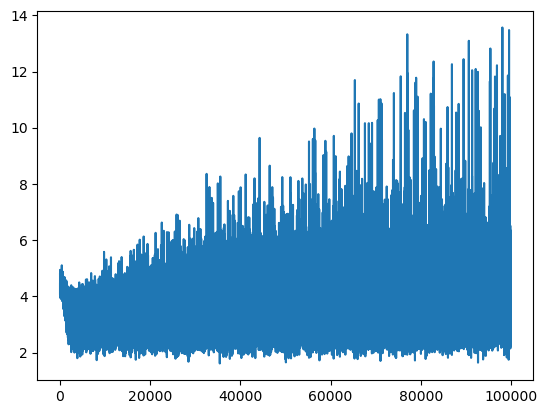

In [148]:
plt.plot(losses)